In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random

<class 'torch.cuda.FloatTensor'>


In [3]:
MORSE_CODE_DICT = { 'A':'.-', 'B':'-...', 
                    'C':'-.-.', 'D':'-..', 'E':'.', 
                    'F':'..-.', 'G':'--.', 'H':'....', 
                    'I':'..', 'J':'.---', 'K':'-.-', 
                    'L':'.-..', 'M':'--', 'N':'-.', 
                    'O':'---', 'P':'.--.', 'Q':'--.-', 
                    'R':'.-.', 'S':'...', 'T':'-', 
                    'U':'..-', 'V':'...-', 'W':'.--', 
                    'X':'-..-', 'Y':'-.--', 'Z':'--..', 
                    '1':'.----', '2':'..---', '3':'...--', 
                    '4':'....-', '5':'.....', '6':'-....', 
                    '7':'--...', '8':'---..', '9':'----.', 
                    '0':'-----', ', ':'--..--', '.':'.-.-.-', 
                    '?':'..--..', '/':'-..-.', '-':'-....-', 
                    '(':'-.--.', ')':'-.--.-'} 

In [4]:
print(MORSE_CODE_DICT['?'], MORSE_CODE_DICT['?'].replace('.', '10').replace('-', '1110'))
print()
morse_code_numpy = {key:np.array([int(x) for x in MORSE_CODE_DICT[key].replace('.', '10').replace('-', '1110')] + [0, 0])
                    for key in MORSE_CODE_DICT.keys()}
for k in morse_code_numpy.keys():
    #if len(morse_code_numpy[k]) == 12:
    #    print(morse_code_numpy[k], k)
    print(morse_code_numpy[k], k)
subset = list(morse_code_numpy.keys())
#subset = ['3', '7', 'Y', 'Q', 'J',
#          'M', 'R', 'U', 'H', 'D']

..--.. 1010111011101010

[1 0 1 1 1 0 0 0] A
[1 1 1 0 1 0 1 0 1 0 0 0] B
[1 1 1 0 1 0 1 1 1 0 1 0 0 0] C
[1 1 1 0 1 0 1 0 0 0] D
[1 0 0 0] E
[1 0 1 0 1 1 1 0 1 0 0 0] F
[1 1 1 0 1 1 1 0 1 0 0 0] G
[1 0 1 0 1 0 1 0 0 0] H
[1 0 1 0 0 0] I
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] J
[1 1 1 0 1 0 1 1 1 0 0 0] K
[1 0 1 1 1 0 1 0 1 0 0 0] L
[1 1 1 0 1 1 1 0 0 0] M
[1 1 1 0 1 0 0 0] N
[1 1 1 0 1 1 1 0 1 1 1 0 0 0] O
[1 0 1 1 1 0 1 1 1 0 1 0 0 0] P
[1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0] Q
[1 0 1 1 1 0 1 0 0 0] R
[1 0 1 0 1 0 0 0] S
[1 1 1 0 0 0] T
[1 0 1 0 1 1 1 0 0 0] U
[1 0 1 0 1 0 1 1 1 0 0 0] V
[1 0 1 1 1 0 1 1 1 0 0 0] W
[1 1 1 0 1 0 1 0 1 1 1 0 0 0] X
[1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0] Y
[1 1 1 0 1 1 1 0 1 0 1 0 0 0] Z
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 1
[1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 2
[1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0] 3
[1 0 1 0 1 0 1 0 1 1 1 0 0 0] 4
[1 0 1 0 1 0 1 0 1 0 0 0] 5
[1 1 1 0 1 0 1 0 1 0 1 0 0 0] 6
[1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 0] 7
[1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0] 8

In [5]:
id2key = subset
key2id = {}
for idx, s in enumerate(subset):
    key2id[s] = idx

X = [ttype(morse_code_numpy[k])for k in subset]
Y = torch.LongTensor(np.arange(0,len(X)))
print(X, Y)

[tensor([1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0.,

# Classes 

In [55]:
class SITHCon_Classifier(nn.Module):
    def __init__(self, out_classes, layer_params, 
                 act_func=nn.ReLU, batch_norm=False,
                 dropout=.2):
        super(SITHCon_Classifier, self).__init__()
        last_channels = layer_params[-1]['channels']
        self.transform_linears = nn.ModuleList([nn.Linear(l['channels'], l['channels'])
                                                for l in layer_params])
        self.sithcon_layers = nn.ModuleList([SITHCon_Layer(l, act_func) for l in layer_params])
        self.to_out = nn.Linear(last_channels, out_classes)
        
        
    def forward(self, inp):
        
        x = inp
        #out = []
        for i in range(len(self.sithcon_layers)):
            x = self.sithcon_layers[i](x)
            
            x = F.relu(self.transform_linears[i](x[:,0,:,:].transpose(1,2)))
            x = x.unsqueeze(1).transpose(2,3)

            #out.append(x.clone())
        x = x.transpose(2,3)[:, 0, :, :]
        #x = x.transpose(2,3)[:, 0, :, :]
        x = self.to_out(x)
        return x

# Functions

In [56]:
def gen_model(p):
    sp1 = dict(in_features=1, 
               tau_min=.1, tau_max=3000, buff_max=6000,
               dt=1, ntau=p[0], k=p[1], g=0.0, ttype=ttype, 
               channels=25, kernel_width=p[2], dilation=p[3],
               dropout=None, batch_norm=None)
    sp2 = dict(in_features=sp1['channels'], 
               tau_min=.1, tau_max=3000, buff_max=6000,
               dt=1, ntau=p[0], k=p[1], g=0.0, ttype=ttype, 
               channels=25, kernel_width=p[2], dilation=p[3], 
               dropout=None, batch_norm=None)
    sp3 = dict(in_features=sp2['channels'], 
               tau_min=.1, tau_max=3000, buff_max=6000,
               dt=1, ntau=p[0], k=p[1], g=0.0, ttype=ttype, 
               channels=25, kernel_width=p[2], dilation=p[3], 
               dropout=None, batch_norm=None)
    layer_params = [sp1, sp2, sp3]
    model = SITHCon_Classifier(len(X), layer_params, act_func=None,#nn.ReLU
                              ).cuda()
    return model

def test_model(model, X, Y):
    model.eval()
    evald = []
    evaldDict = {'test_perf':[],
                 'rate':[],
                 'tau_max':[],
                 'ntau':[],
                 'k':[],
                 'dilation':[],
                 'channels':[]}
    for nr in [1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]:
    #for nr in range(1,40,):
        perfs = []
        for batch_idx, iv in enumerate(X):
            iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
            iv = iv.unsqueeze(-1)
            iv = iv.repeat(1,1,1,1,nr)
            iv = iv.reshape(1,1,1,-1)
            tv = Y[batch_idx].to(device)
            out = model(iv)
            loss = loss_func(out[:, -1, :],
                             torch.cuda.LongTensor([tv]))


            perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                          tv).sum().item()*1.0)
        evaldDict['test_perf'].append(sum(perfs)/len(perfs))
        evaldDict['rate'].append(nr)
        evaldDict['tau_max'].append(model.sithcon_layers[0].sithcon.sith.tau_max)
        evaldDict['ntau'].append(model.sithcon_layers[0].sithcon.sith.ntau)
        evaldDict['k'].append(model.sithcon_layers[0].sithcon.sith.k)
        evaldDict['dilation'].append(model.sithcon_layers[0].sithcon.dilation)
        evaldDict['channels'].append(model.sithcon_layers[0].sithcon.channels)

    return evaldDict

def save_outcome(outcome, filename):
    dat = pd.DataFrame(outcome)
    dat.to_csv(join('perf',filename))

In [8]:
model.sithcon_layers[0].sithcon.sith.k

NameError: name 'model' is not defined

# Testing

In [33]:
Trainscale = 10
sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=200.0, buff_max=2000,
           dt=1, ntau=413, k=30, g=0.0, ttype=ttype, 
           channels=50, kernel_width=20, dilation=3,
           dropout=None, batch_norm=None)
layer_params = [sp1]

model = SITHCon_Classifier(len(X), layer_params, act_func=nn.ReLU).cuda()
print(model.sithcon_layers[0].sithcon.sith.c)

0.01862002272446439


In [58]:
print(model.sithcon_layers[0].sithcon.sith.tau_max)

200.0


In [56]:
params = [[1000.0, 2000.0, 500], 
           [800.0, 1600.0, 488], 
           [600.0, 1200.0, 472],
           [400.0, 800.0, 451],
           [200.0, 400.0, 413],]

# Go!

In [59]:
45*3

135

In [36]:
params = [[400, 35, 45, 1],
          [400, 35, 23, 2],
           [400, 35, 15, 3],]

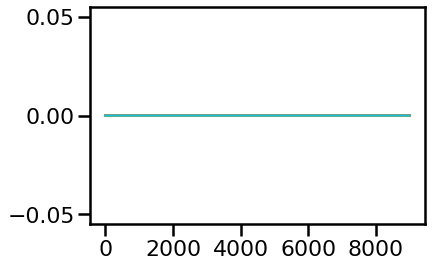

In [50]:
p = params[2]
sp1 = dict(in_features=1, 
       tau_min=.1, tau_max=3000., buff_max=6000.,
       dt=1, ntau=p[0], k=p[1], g=1.0, ttype=ttype, 
       channels=25, kernel_width=p[2], dilation=3,
       dropout=None, batch_norm=None)

ev1 = iSITH(tau_min=sp1['tau_min'], tau_max=sp1['tau_max'], buff_max=sp1['tau_max']*3, 
           k=sp1['k'], ntau=sp1['ntau'], dt=sp1['dt'], g=sp1['g'])
#plt.plot(ev1.tau_star)
plt.plot(ev1.filters[:10, 0, 0, :, ].detach().cpu().T.numpy()[::-1], linewidth=2
   );

In [46]:
for i, p in enumerate(params):
    
    model = gen_model(p)
    
    tot_weights = 0
    for p in model.parameters():
        tot_weights += p.numel()
    print("Total Weights:", tot_weights)
    
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    epochs = 1500
    Trainscale = 10
    device='cuda'
    progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
    epochperfs = []
    times_100 = 0
    for epoch_idx in progress_bar:
        perfs = []
        losses = []
        model.train()
        for batch_idx, iv in enumerate(X):
            iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
            iv = iv.unsqueeze(-1)
            iv = iv.repeat(1,1,1,1,Trainscale)
            iv = iv.reshape(1,1,1,-1)
            tv = Y[batch_idx].to(device)
            optimizer.zero_grad()
            out = model(iv)
            loss = loss_func(out[:, -1, :],
                             torch.cuda.LongTensor([tv]))
            loss.backward()
            optimizer.step()

            perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                          tv).sum().item())
            #perfs = perfs[int(-loss_buffer_size/batch_size):]
            losses.append(loss.detach().cpu().numpy())
            #losses = losses[int(-loss_buffer_size/batch_size):]


            s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
            format_list = [epoch_idx, batch_idx, np.mean(losses), 
                           np.sum(perfs)/((len(perfs)))]
            s = s.format(*format_list)
            progress_bar.set_description(s)
            epochperfs.append(format_list)
        if np.sum(perfs)/((len(perfs))) == 1.0:
            times_100 += 1
            if times_100 >= 3:
                break
    outcome = test_model(model, X, Y)
    #ave_outcome(outcome, filename='SITHCon_MORSE_cntau_dilation_{:02}.csv'.format(i))
    print(outcome)
    torch.save(model.state_dict(), 'SITHCon_MORSE_3000ntau_test2_{:02}.pt'.format(i))
    save_outcome(outcome, filename='SITHCon_MORSE_3000ntau_test2_{:02}.csv'.format(i))

Total Weights: 60518



{'test_perf': [0.06976744186046512, 0.23255813953488372, 0.9302325581395349, 0.9767441860465116, 0.9767441860465116, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'rate': [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40], 'tau_max': [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000], 'ntau': [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400], 'k': [35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35], 'dilation': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'channels': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]}
Total Weights: 32468



{'test_perf': [0.046511627906976744, 0.13953488372093023, 0.7674418604651163, 0.8837209302325582, 0.9767441860465116, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9767441860465116, 0.9534883720930233], 'rate': [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40], 'tau_max': [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000], 'ntau': [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400], 'k': [35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35], 'dilation': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'channels': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]}
Total Weights: 22268



{'test_perf': [0.11627906976744186, 0.5116279069767442, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'rate': [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40], 'tau_max': [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000], 'ntau': [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400], 'k': [35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35], 'dilation': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'channels': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]}


In [ ]:
torch.save(model.state_dict(), PATH)

In [33]:
outcome = test_model(model, X, Y)
save_outcome(outcome, filename='SITHCon_MORSE_cntau_{:02}.csv'.format(99))

In [22]:
dat1 = pd.read_csv(join('perf','SITHCon_morse_perf.csv'))
print(dat1)
dat2 = pd.read_csv(join('perf','DeepSITH_morse_perf.csv'))
dat2

    Unnamed: 0  test_perf  rate
0            0   0.186047     1
1            1   0.627907     2
2            2   1.000000     5
3            3   1.000000     6
4            4   1.000000     7
5            5   1.000000     8
6            6   1.000000     9
7            7   1.000000    10
8            8   1.000000    11
9            9   1.000000    12
10          10   1.000000    13
11          11   1.000000    14
12          12   1.000000    15
13          13   1.000000    16
14          14   1.000000    17
15          15   1.000000    18
16          16   1.000000    19
17          17   1.000000    20
18          18   1.000000    30
19          19   0.790698    40


,Unnamed: 0,test_perf,rate
0,0,0.000000,1
1,1,0.023256,2
2,2,0.023256,5
3,3,0.023256,6
4,4,0.046512,7
5,5,0.093023,8
6,6,0.534884,9
7,7,1.000000,10
8,8,0.465116,11
9,9,0.093023,12


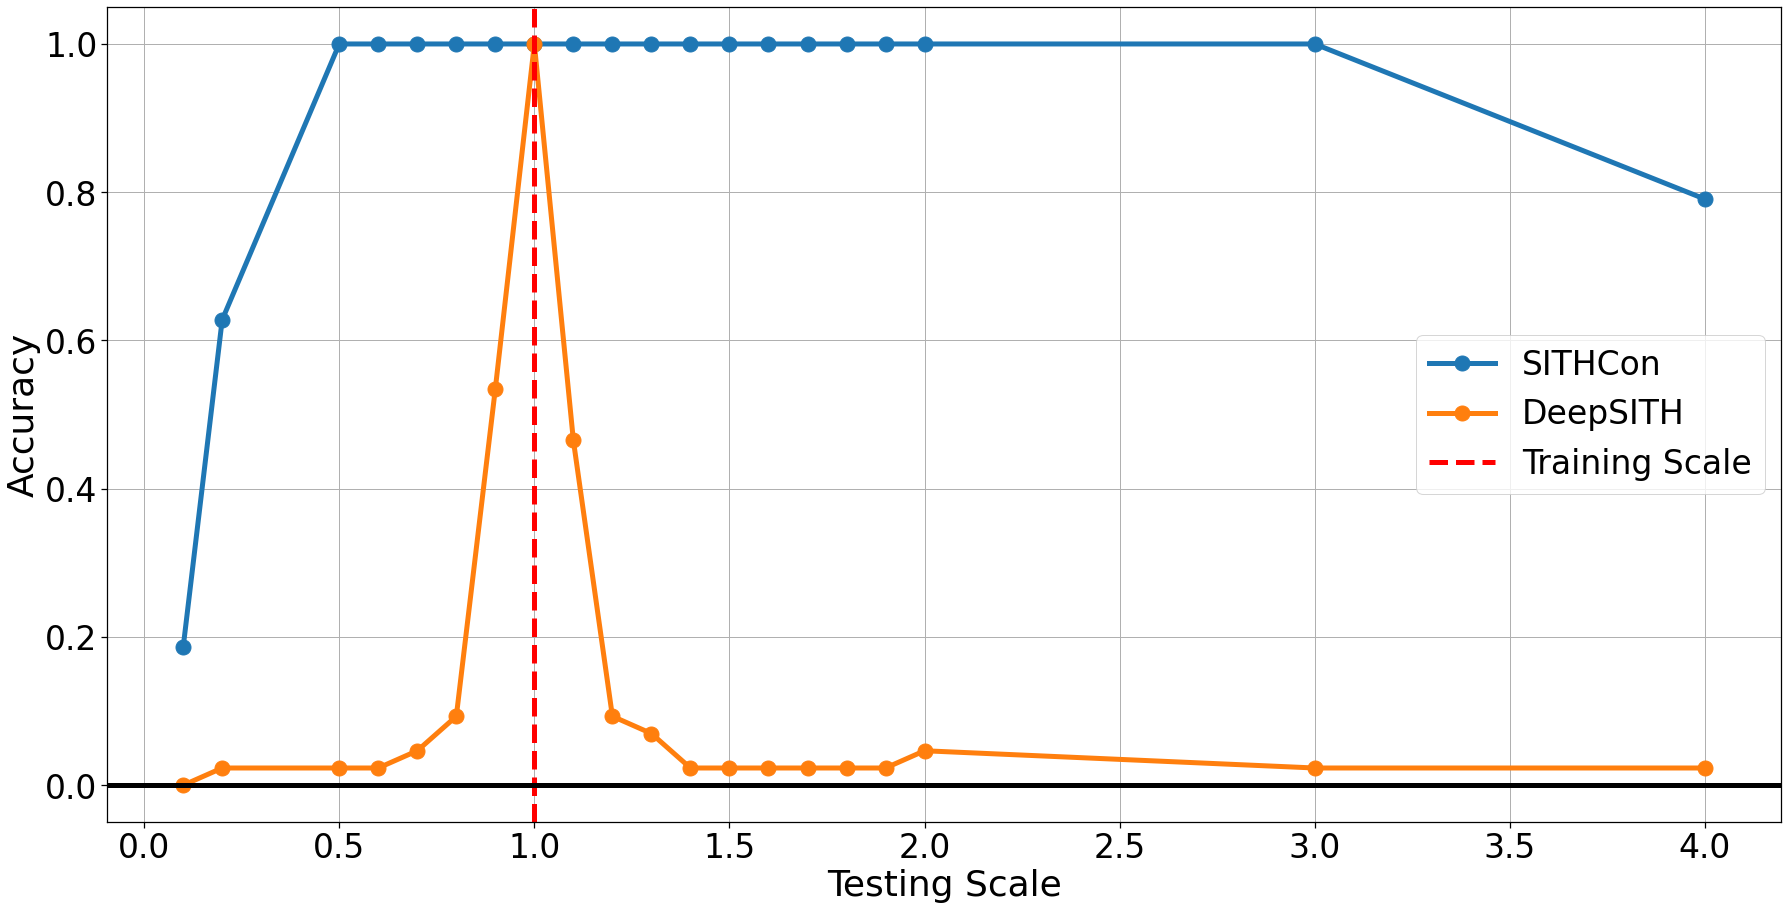

In [26]:
window_size = 20
lw=5
ms = 15
with sn.plotting_context("notebook", font_scale=3):
    fig=plt.figure(figsize=(30,15))
    Trainscale = 10
    plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
            linewidth=lw, ms=ms)
    plt.plot(dat2.rate/Trainscale, dat2.test_perf, marker='o',
            linewidth=lw, ms=ms)
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend(['SITHCon', 'DeepSITH', 'Training Scale'])
plt.savefig(join('figs', 'perf3layers'), dpi=100)

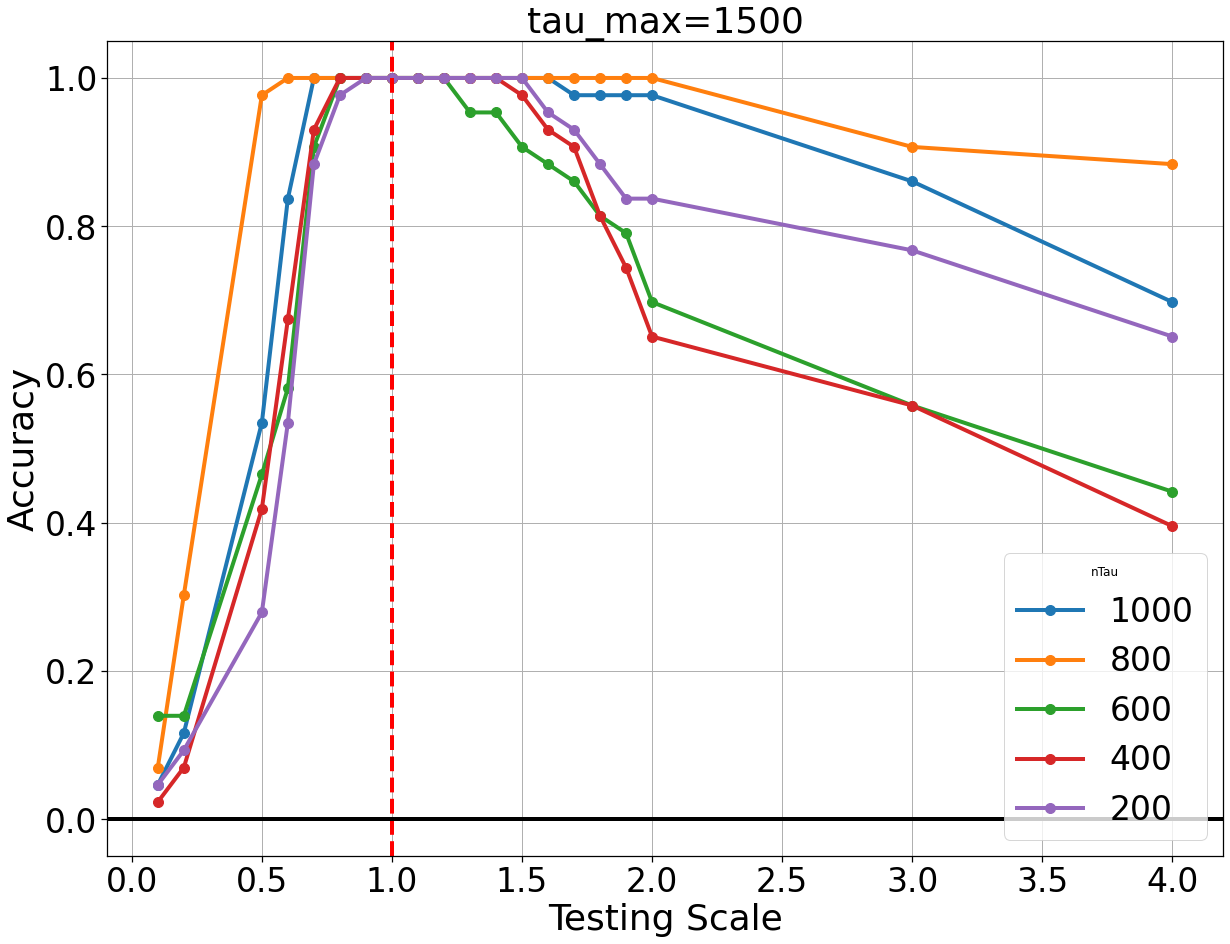

In [51]:
window_size = 20
lw=4
ms = 10
with sn.plotting_context("notebook", font_scale=3):
    
    fig=plt.figure(figsize=(20,15))
    Trainscale = 10
    for i in range(5):
        dat1 = pd.read_csv(join('perf','SITHCon_MORSE_cntau_{:02}.csv'.format(i)))
        plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
                linewidth=lw, ms=ms)
        
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend([1000, 800, 600, 400, 200], title='nTau')
    plt.title("tau_max=1500")
plt.savefig(join('figs', 'perf3layers_ntau_diff'), dpi=100)


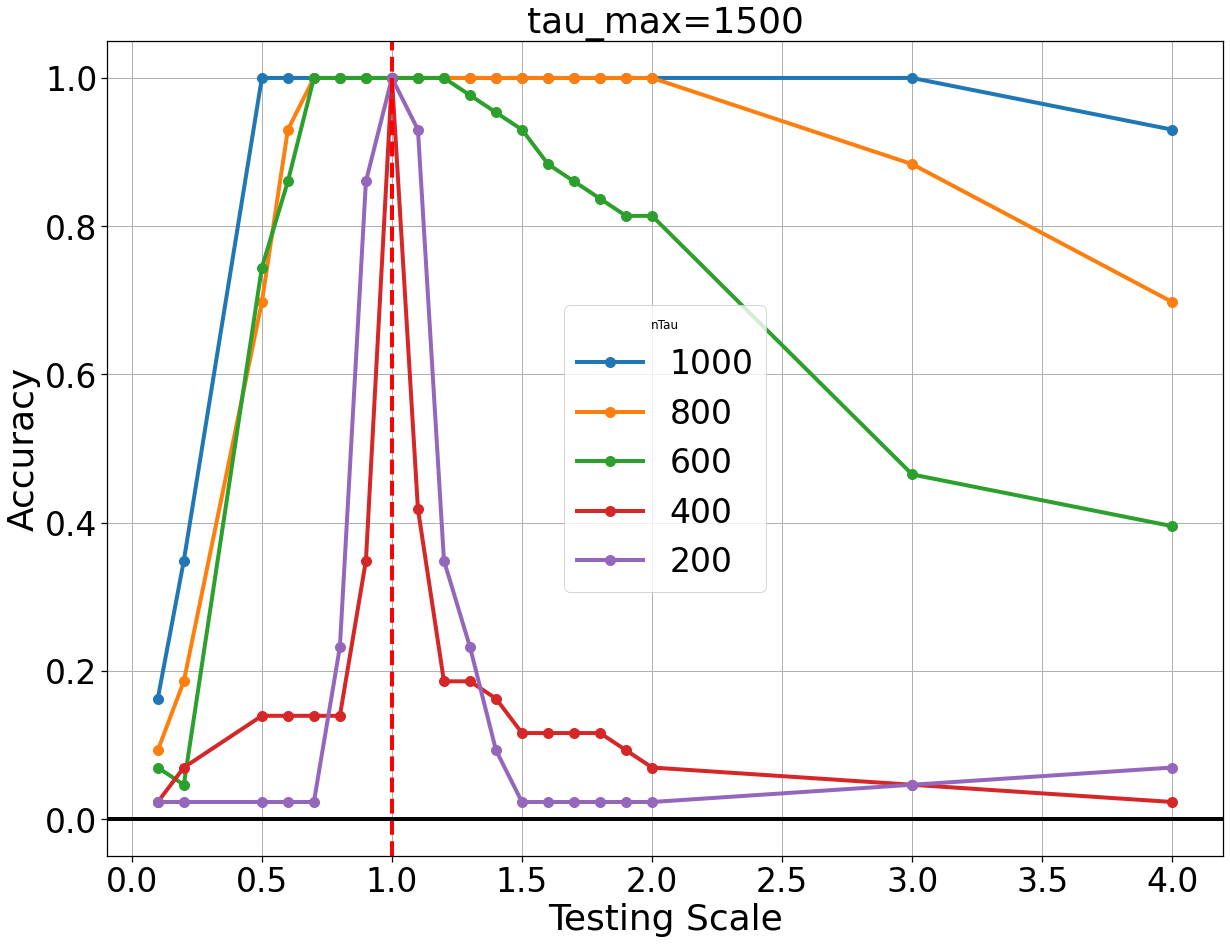

In [58]:
window_size = 20
lw=4
ms = 10
with sn.plotting_context("notebook", font_scale=3):
    
    fig=plt.figure(figsize=(20,15))
    Trainscale = 10
    for i in range(5):
        dat1 = pd.read_csv(join('perf','SITHCon_MORSE_cntau_kkerfixed_{:02}.csv'.format(i)))
        plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
                linewidth=lw, ms=ms)
        
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend([1000, 800, 600, 400, 200], title='nTau')
    plt.title("tau_max=1500")
plt.savefig(join('figs', 'perf3layers_ntau_onlydiff'), dpi=100)


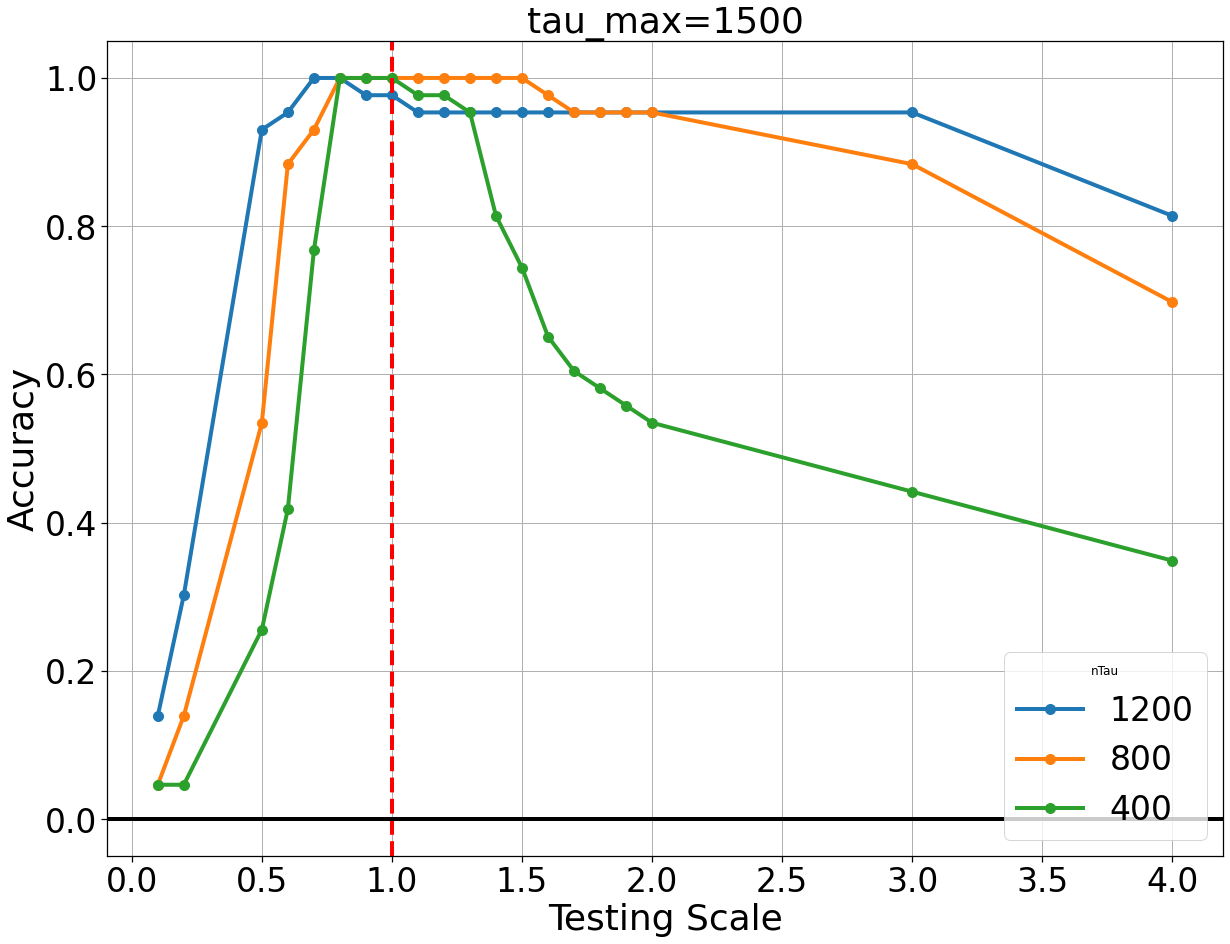

In [26]:
window_size = 20
lw=4
ms = 10
with sn.plotting_context("notebook", font_scale=3):
    
    fig=plt.figure(figsize=(20,15))
    Trainscale = 10
    for i in range(3):
        dat1 = pd.read_csv(join('perf','SITHCon_MORSE_cntau_dilation_{:02}.csv'.format(i)))
        plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
                linewidth=lw, ms=ms)
        
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend([1200, 800, 400], title='nTau')
    plt.title("tau_max=1500")
plt.savefig(join('figs', 'perf3layers_ntau_cdilation'), dpi=100)


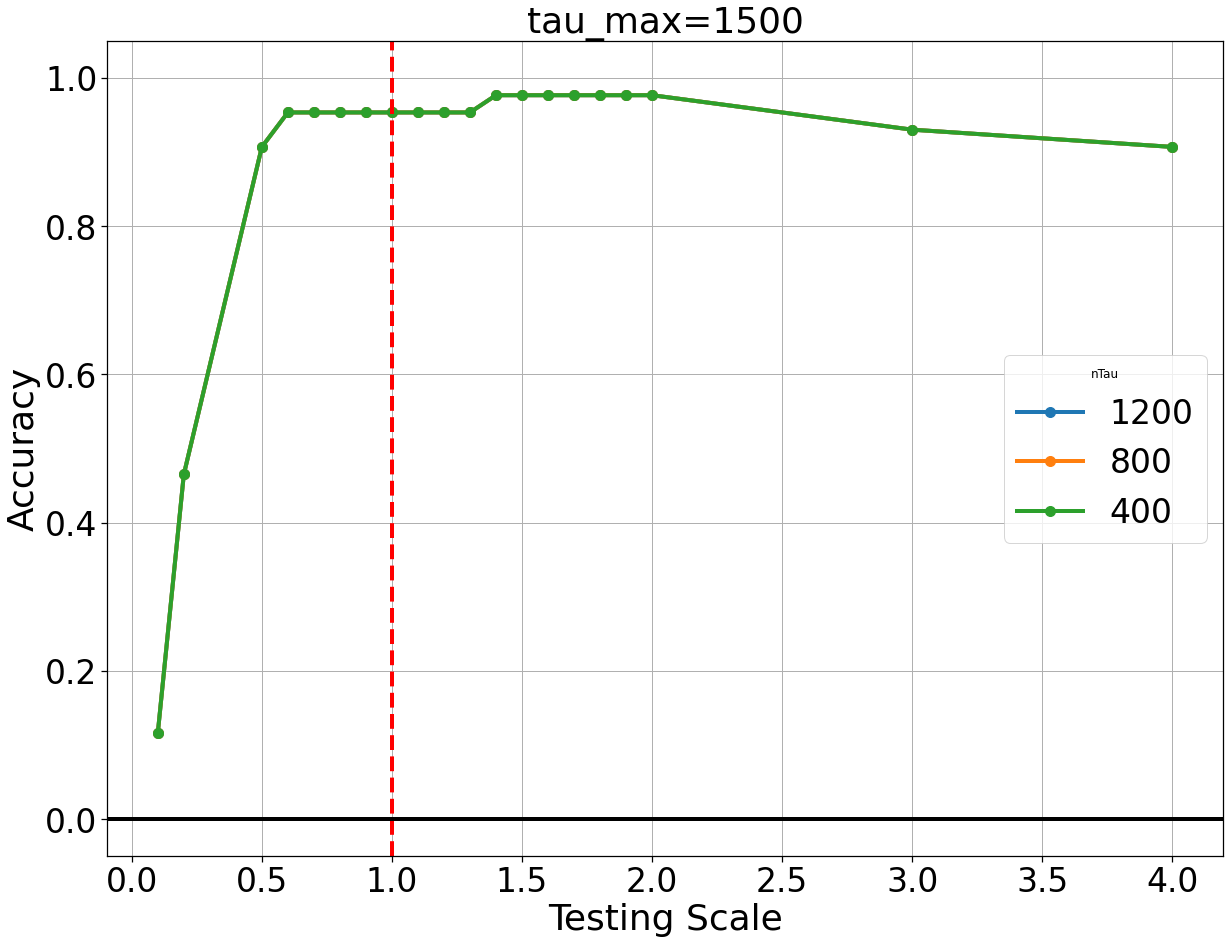

In [34]:
window_size = 20
lw=4
ms = 10
with sn.plotting_context("notebook", font_scale=3):
    
    fig=plt.figure(figsize=(20,15))
    Trainscale = 10
    for i in range(3):
        dat1 = pd.read_csv(join('perf','SITHCon_MORSE_cntau_{:02}.csv'.format(99)))
        plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
                linewidth=lw, ms=ms)
        
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend([1200, 800, 400], title='nTau')
    plt.title("tau_max=1500")
plt.savefig(join('figs', 'perf3layers_ntau_cdilation'), dpi=100)


   Unnamed: 0  test_perf  rate  tau_max  ntau   k
0           0   0.093023     1     3000  1200  35
1           1   0.395349     2     3000  1200  35
2           2   1.000000     5     3000  1200  35
3           3   1.000000     6     3000  1200  35
4           4   1.000000     7     3000  1200  35
   Unnamed: 0  test_perf  rate  tau_max  ntau   k
0           0   0.186047     1     3000   800  35
1           1   0.418605     2     3000   800  35
2           2   0.906977     5     3000   800  35
3           3   0.953488     6     3000   800  35
4           4   0.953488     7     3000   800  35
   Unnamed: 0  test_perf  rate  tau_max  ntau   k
0           0   0.116279     1     3000   400  35
1           1   0.255814     2     3000   400  35
2           2   0.976744     5     3000   400  35
3           3   0.976744     6     3000   400  35
4           4   0.976744     7     3000   400  35


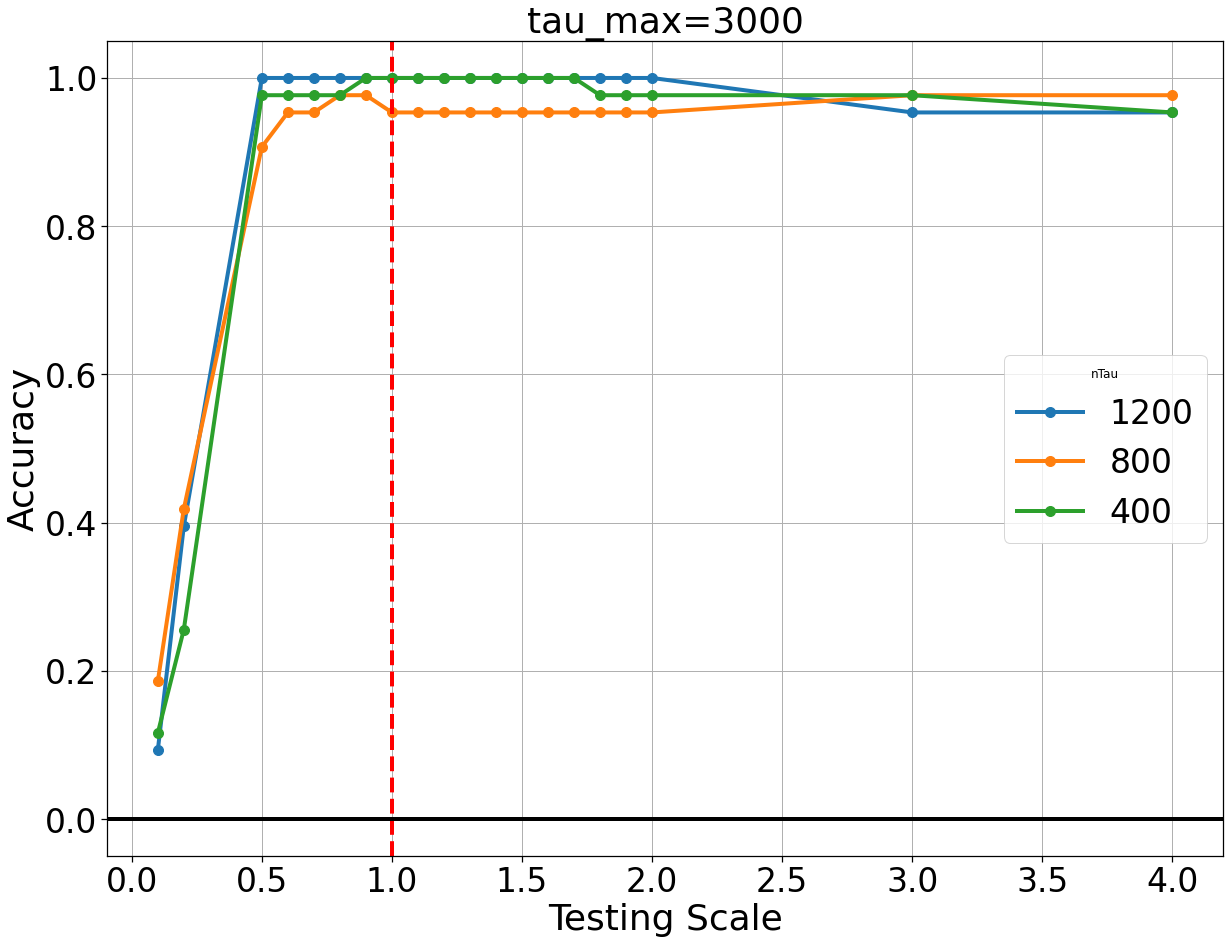

In [57]:
window_size = 20
lw=4
ms = 10
with sn.plotting_context("notebook", font_scale=3):
    
    fig=plt.figure(figsize=(20,15))
    Trainscale = 10
    for i in range(3):
        dat1 = pd.read_csv(join('perf','SITHCon_MORSE_3000ntau_dilationchange_{:02}.csv'
.format(i)))
        print(dat1.head())
        plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
                linewidth=lw, ms=ms)
        
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend([1200, 800, 400], title='nTau')
    plt.title("tau_max=3000")
plt.savefig(join('figs', 'perf3layers_ntau_cdilation'), dpi=100)


In [23]:
torch.load('SITHCon_MORSE_3000ntau_dilationsame_{:02}.pt'.format(1))

FileNotFoundError: [Errno 2] No such file or directory: 'SITHCon_MORSE_3000ntau_dilationsame_01.pt'

   Unnamed: 0  test_perf  rate  tau_max  ntau   k
0           0   0.046512     1     3000  1200  35
1           1   0.209302     2     3000  1200  35
2           2   0.953488     5     3000  1200  35
3           3   1.000000     6     3000  1200  35
4           4   1.000000     7     3000  1200  35
   Unnamed: 0  test_perf  rate  tau_max  ntau   k
0           0   0.046512     1     3000   800  35
1           1   0.046512     2     3000   800  35
2           2   0.441860     5     3000   800  35
3           3   0.697674     6     3000   800  35
4           4   0.930233     7     3000   800  35
   Unnamed: 0  test_perf  rate  tau_max  ntau   k
0           0   0.023256     1     3000   400  35
1           1   0.023256     2     3000   400  35
2           2   0.209302     5     3000   400  35
3           3   0.465116     6     3000   400  35
4           4   0.581395     7     3000   400  35


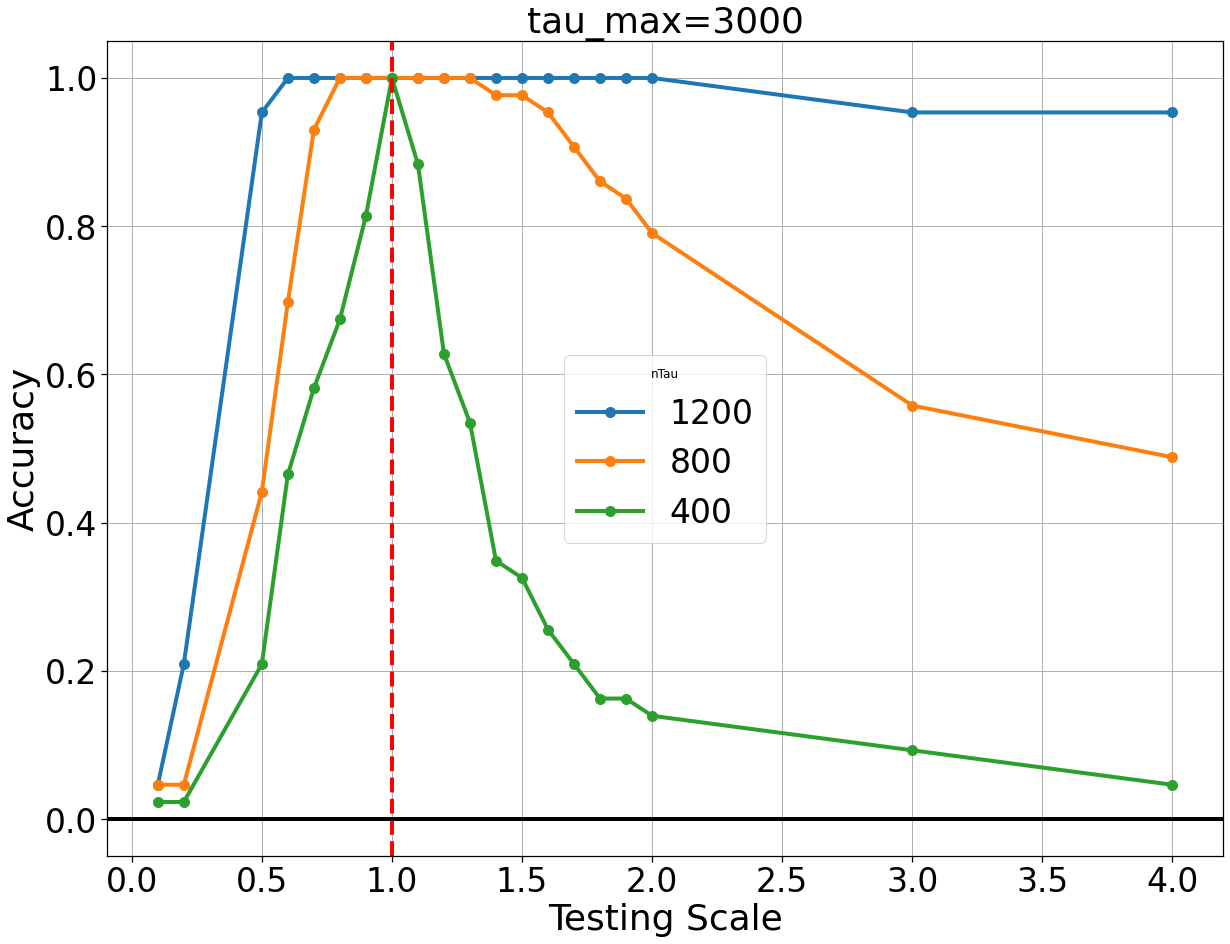

In [12]:
window_size = 20
lw=4
ms = 10
with sn.plotting_context("notebook", font_scale=3):
    
    fig=plt.figure(figsize=(20,15))
    Trainscale = 10
    for i in range(3):
        dat1 = pd.read_csv(join('perf','SITHCon_MORSE_3000ntau_dilationsame_{:02}.csv'
.format(i)))
        print(dat1.head())
        plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
                linewidth=lw, ms=ms)
        
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend([1200, 800, 400], title='nTau')
    plt.title("tau_max=3000")
plt.savefig(join('figs', 'perf3layers_ntau_cdilation'), dpi=100)

   Unnamed: 0  test_perf  rate  tau_max  ntau   k  dilation  channels
0           0   0.023256     1     3000   400  35         1        25
1           1   0.023256     2     3000   400  35         1        25
2           2   0.232558     5     3000   400  35         1        25
3           3   0.348837     6     3000   400  35         1        25
4           4   0.441860     7     3000   400  35         1        25
   Unnamed: 0  test_perf  rate  tau_max  ntau   k  dilation  channels
0           0   0.046512     1     3000   400  35         2        25
1           1   0.232558     2     3000   400  35         2        25
2           2   0.813953     5     3000   400  35         2        25
3           3   0.930233     6     3000   400  35         2        25
4           4   0.976744     7     3000   400  35         2        25
   Unnamed: 0  test_perf  rate  tau_max  ntau   k  dilation  channels
0           0   0.046512     1     3000   400  35         3        25
1           1   0.04

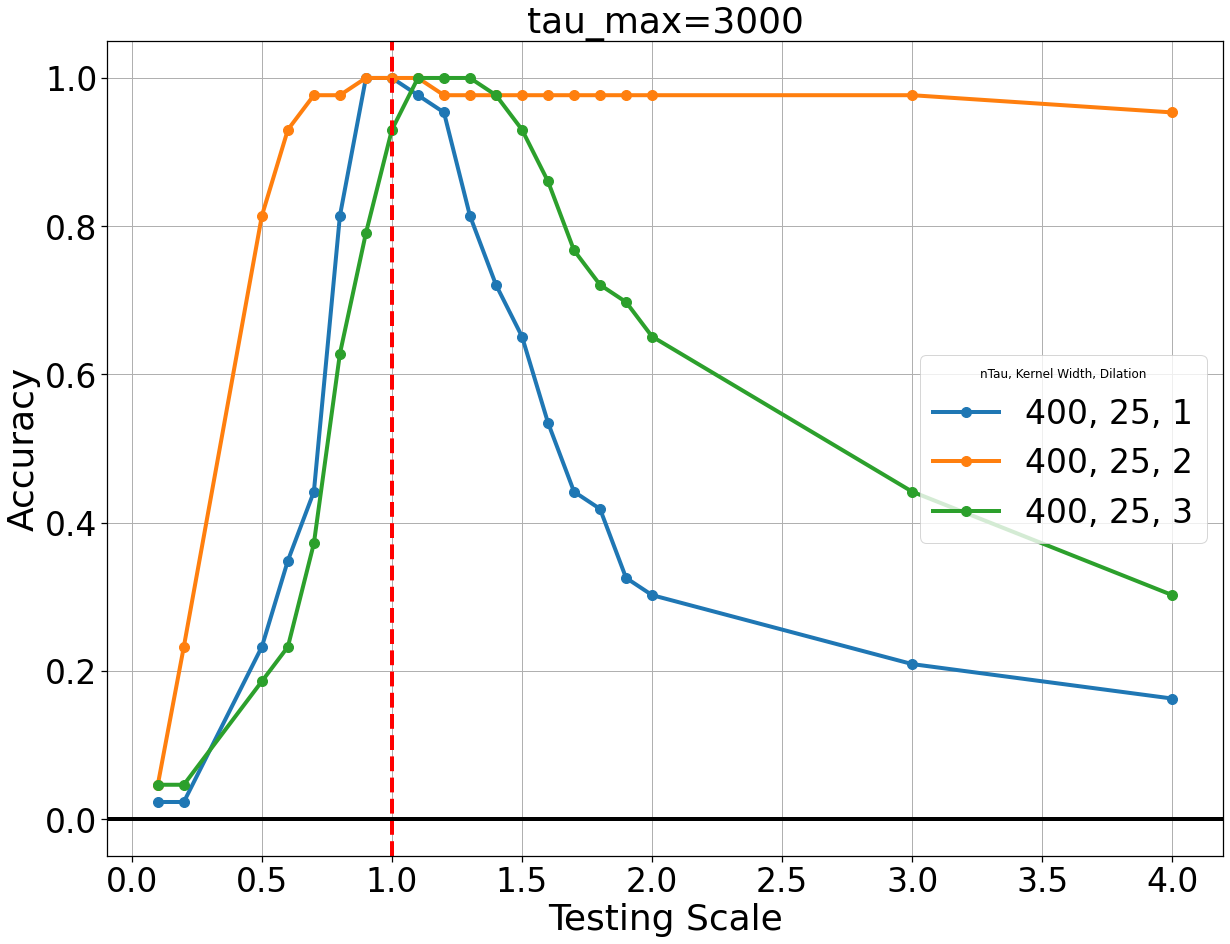

In [54]:

window_size = 20
lw=4
ms = 10
with sn.plotting_context("notebook", font_scale=3):
    
    fig=plt.figure(figsize=(20,15))
    Trainscale = 10
    for i in range(3):
        dat1 = pd.read_csv(join('perf','SITHCon_MORSE_3000ntau_test_{:02}.csv'.format(i)))
        print(dat1.head())
        plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
                linewidth=lw, ms=ms)
        
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend(["400, 25, 1",
                "400, 25, 2",
                "400, 25, 3"
               ], title='nTau, Kernel Width, Dilation')
    plt.title("tau_max=3000")
plt.savefig(join('figs', 'perf3layers_ntau_cdilation'), dpi=100)

   Unnamed: 0  test_perf  rate  tau_max  ntau   k  dilation  channels
0           0   0.069767     1     3000   400  35         1        25
1           1   0.232558     2     3000   400  35         1        25
2           2   0.930233     5     3000   400  35         1        25
3           3   0.976744     6     3000   400  35         1        25
4           4   0.976744     7     3000   400  35         1        25
   Unnamed: 0  test_perf  rate  tau_max  ntau   k  dilation  channels
0           0   0.046512     1     3000   400  35         2        25
1           1   0.139535     2     3000   400  35         2        25
2           2   0.767442     5     3000   400  35         2        25
3           3   0.883721     6     3000   400  35         2        25
4           4   0.976744     7     3000   400  35         2        25
   Unnamed: 0  test_perf  rate  tau_max  ntau   k  dilation  channels
0           0   0.116279     1     3000   400  35         3        25
1           1   0.51

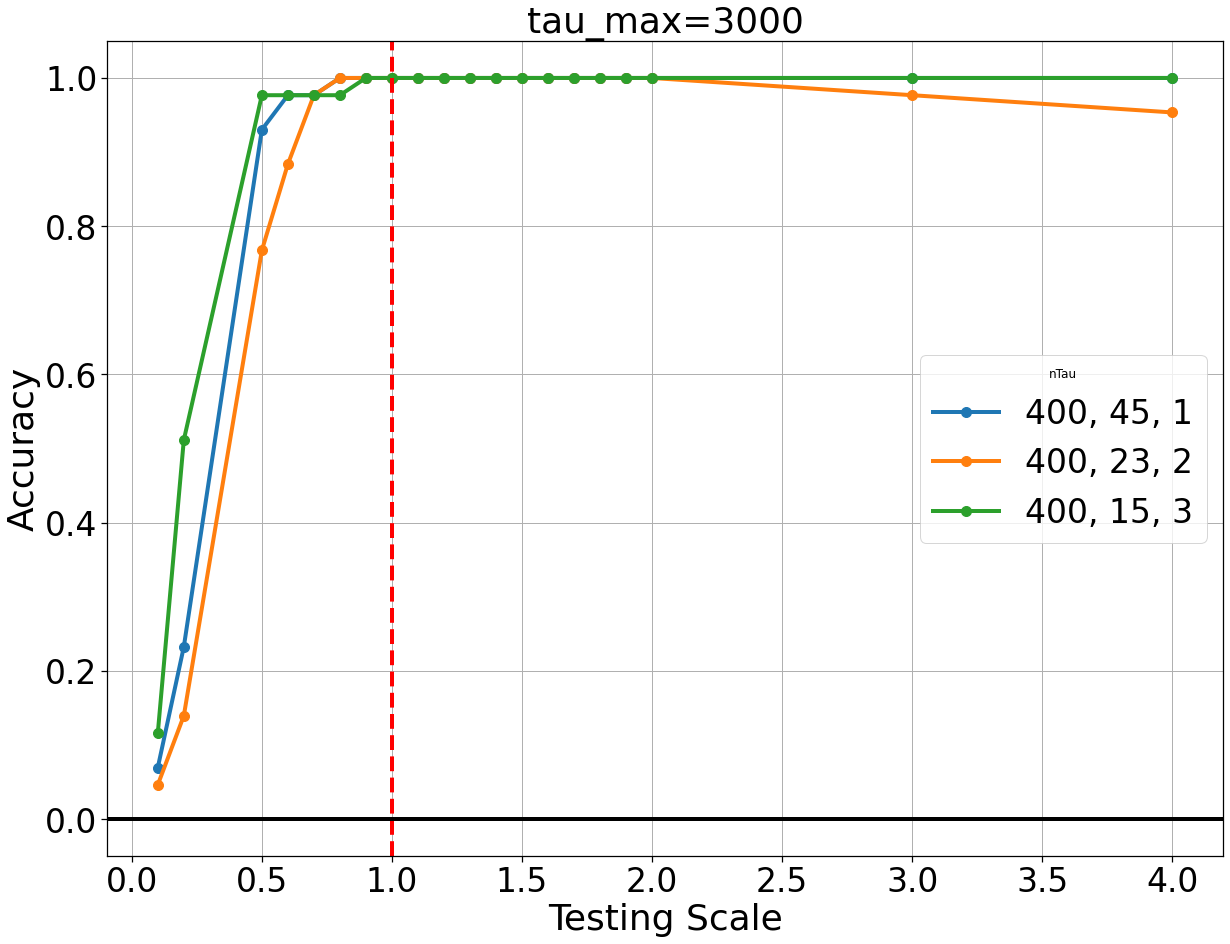

In [47]:

window_size = 20
lw=4
ms = 10
with sn.plotting_context("notebook", font_scale=3):
    
    fig=plt.figure(figsize=(20,15))
    Trainscale = 10
    for i in range(3):
        dat1 = pd.read_csv(join('perf','SITHCon_MORSE_3000ntau_test2_{:02}.csv'.format(i)))
        print(dat1.head())
        plt.plot(dat1.rate/Trainscale, dat1.test_perf, marker='o',
                linewidth=lw, ms=ms)
        
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Accuracy')
    plt.xlabel('Testing Scale')
    plt.legend(["400, 45, 1",
                "400, 23, 2",
                "400, 15, 3"
               ], title='nTau')
    plt.title("tau_max=3000")
plt.savefig(join('figs', 'perf3layers_ntau_cdilation'), dpi=100)